In [ ]:
import sys; sys.path.append('..')
from zeroptim.optimizers.mezo import MeZO
from zeroptim.optimizers.smartes import SmartES

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import trange
import matplotlib.pyplot as plt

/Users/apinto/.virtualenvs/pytorch-mezo-qrlr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 64
hidden_dim = 16

def make_model():
    torch.manual_seed(0)
    m = nn.Linear(hidden_dim+1, hidden_dim, bias=False)
    # print("model: ", m, m.weight.shape, round(m.weight.sum().item(), 4))
    return m


def benchmark_train(model, opt, train_iter=10000):
    torch.manual_seed(0)
    inputs  = torch.randn(batch_size, hidden_dim+1)
    torch.manual_seed(0)
    f = nn.Linear(hidden_dim+1, hidden_dim, bias=False)
    # print("target: ", f, f.weight.shape, round(f.weight.sum().item(), 4))
    targets = f(inputs).detach()

    def closure(with_backward=False):
        opt.zero_grad()
        outputs = model(inputs)
        loss = 0.5 * (targets - outputs).pow(2).mean()
        if with_backward:
            loss.backward()
        return loss

    losses = []
    for _ in (pbar:=trange(train_iter)):
        loss = opt.step(lambda: closure(with_backward=not isinstance(opt, (MeZO, SmartES))))
        pbar.set_description(f'{loss:.3f}')
        losses.append(loss.item())
    
    # print("model_t: ", model, model.weight.shape, round(model.weight.sum().item(), 4),"\n")
    return losses


# sgd
model = make_model()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
sgd_losses = benchmark_train(model, opt)

# sgd-mezo
model = make_model()
opt = MeZO(torch.optim.SGD(model.parameters(), lr=0.05), eps=1e-3) 
sgd_mezo_losses = benchmark_train(model, opt)

# sgd-smartes
model = make_model()
opt = SmartES(torch.optim.AdamW(model.parameters(), lr=0.005), model, eps=1e-3)
sgd_smartes_losses = benchmark_train(model, opt)

# adamW
model = make_model()
opt = torch.optim.AdamW(model.parameters(), lr=0.1)
adam_losses = benchmark_train(model, opt)

# adamW-mezo
model = make_model()
opt = MeZO(torch.optim.AdamW(model.parameters(), lr=0.005), eps=1e-3)  
adam_mezo_losses = benchmark_train(model, opt)

# adamW-smartes
model = make_model()
opt = SmartES(torch.optim.AdamW(model.parameters(), lr=0.005), model, eps=1e-3)
adam_smartes_losses = benchmark_train(model, opt)

0.021: 100%|██████████| 10000/10000 [00:15<00:00, 665.62it/s]


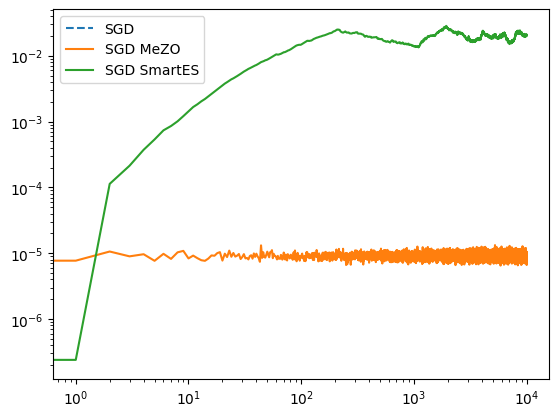

In [3]:
plt.figure()
plt.plot(sgd_losses, label='SGD', color='C0', linestyle='--')
plt.plot(sgd_mezo_losses, label='SGD MeZO', color='C1', linestyle='-')
plt.plot(sgd_smartes_losses, label='SGD SmartES', color='C2', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

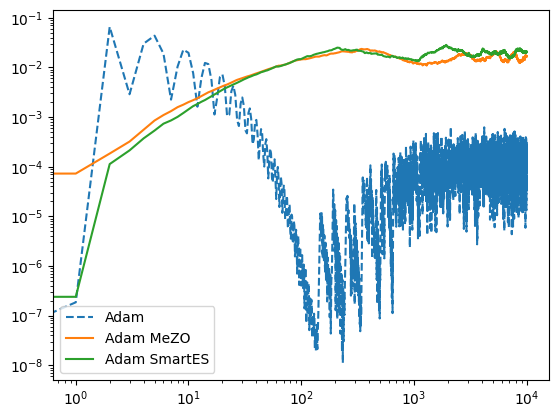

In [4]:
plt.figure()
plt.plot(adam_losses, label='Adam', color='C0', linestyle='--')
plt.plot(adam_mezo_losses, label='Adam MeZO', color='C1', linestyle='-')
plt.plot(adam_smartes_losses, label='Adam SmartES', color='C2', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()